In [19]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
import albumentations as albu

In [20]:
os.chdir("/workspace/")

In [21]:
DATA_DIR = pathlib.Path('./data/CamVid/')

# load repo with data if it is not exists
if not DATA_DIR.exists():
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [22]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [23]:
def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True)
    ]
    return albu.Compose(train_transform)
    
def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x: np.ndarray, **kargs):
    return torch.tensor(x.transpose(2, 0, 1), dtype=torch.float)

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn) if preprocessing_fn is not None else albu.Compose([]),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]
    return albu.Compose(_transform)

In [24]:
# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [25]:
# パラメータ
ENCODER = 'se_resnext50_32x4d' # バックボーンネットワークの指定
ENCODER_WEIGHTS = 'imagenet' # 使用する学習済みモデル
ACTIVATION = None # 恒等関数や、マルチクラス用に'softmax2d'にする場合は'None'へ
CLASSES = [
    "sky",
    "building",
    "pole",
    "road",
    "pavement",
    "tree",
    "signsymbol",
    "fence",
    "car",
    "pedestrian",
    "bicyclist",
    "unlabelled"
]
DEVICE = 'cuda'

In [26]:
class MyDataset(Dataset):
    
    CLASSES = [
        "sky",
        "building",
        "pole",
        "road",
        "pavement",
        "tree",
        "signsymbol",
        "fence",
        "car",
        "pedestrian",
        "bicyclist",
        "unlabelled"
    ]
    
    def __init__(
        self,
        images_dir,
        masks_dir,
        classes=[],
        augmentation=None,
        preprocessing=None
    ) -> None:
        self.ids = os.listdir(images_dir)
        self.images = [os.path.join(images_dir, id) for id in self.ids]
        self.masks = [os.path.join(masks_dir, id) for id in self.ids]
        
        # クラス名の文字列
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __len__(self) -> int:
        return len(self.ids)
        
    # 3. 学習用データ(image)と特徴(mask)を返す__getitem__メソッドを作成
    def __getitem__(self, i):
        
        # データの読み込み
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], 0)
        
        # 学習対象のクラス(例えば、'car')のみを抽出
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('uint')
        # print("mask.shape", mask.shape)
        
        # augmentation関数の適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # 前処理関数の適用
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
# SMPを用いて学習済みモデルを取得(アーキテクチャはFPN)
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model = model.to(device=DEVICE).type(torch.float)

In [29]:
# 損失関数
loss = smp_utils.losses.DiceLoss(activation="softmax2d")

# 評価関数
metrics = [
    smp_utils.metrics.IoU(threshold=0.5)
]

# 最適化関数
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [30]:
from torch.utils.data import DataLoader


# データセットのインスタンスを作成
train_dataset = MyDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(None),
    classes=CLASSES,
)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

In [31]:
from torch.utils.data import DataLoader

# データセットのインスタンスを作成
val_dataset = MyDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(None),
    classes=CLASSES,
)

# データローダーの作成
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=12)

In [32]:
print(model)

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

In [33]:
train_epoch = smp_utils.train.TrainEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

In [34]:
epochs = 40
max_score = 0

if not pathlib.Path("best_model.pth").exists():
    for epoch in range(1, epochs + 1):
        print(f"\n Epoch: {epoch}")
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)
        # 評価関数の値が更新されたらモデルを保存
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

        # エポック25以降は学習率(learning rate)を下げる      
        if epoch == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')
        


 Epoch: 1
valid: 100%|██████████| 13/13 [00:02<00:00,  6.02it/s, dice_loss - 0.4019, iou_score - 0.2568]
Model saved!

 Epoch: 2
valid: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s, dice_loss - 0.3322, iou_score - 0.3299]
Model saved!

 Epoch: 3
valid: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s, dice_loss - 0.2089, iou_score - 0.3107]

 Epoch: 4
valid: 100%|██████████| 13/13 [00:02<00:00,  6.25it/s, dice_loss - 0.1885, iou_score - 0.3386]
Model saved!

 Epoch: 5
valid: 100%|██████████| 13/13 [00:02<00:00,  6.09it/s, dice_loss - 0.1877, iou_score - 0.3551]
Model saved!

 Epoch: 6
valid: 100%|██████████| 13/13 [00:02<00:00,  6.21it/s, dice_loss - 0.1914, iou_score - 0.3552]
Model saved!

 Epoch: 7
valid: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s, dice_loss - 0.1879, iou_score - 0.3504]

 Epoch: 8
valid: 100%|██████████| 13/13 [00:02<00:00,  6.25it/s, dice_loss - 0.1853, iou_score - 0.3518]

 Epoch: 9
valid: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s, dice_loss - 0.1304, i

KeyboardInterrupt: 

In [35]:
# 可視化用の画像を取得するデータセットを作成(Augmentationなし)
test_dataset_vis = MyDataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

157
torch.Size([3, 384, 480])
torch.Size([1, 12, 384, 480])
torch.Size([1, 384, 480])
(384, 480) torch.Size([12, 384, 480])
(384, 480) torch.Size([384, 480])


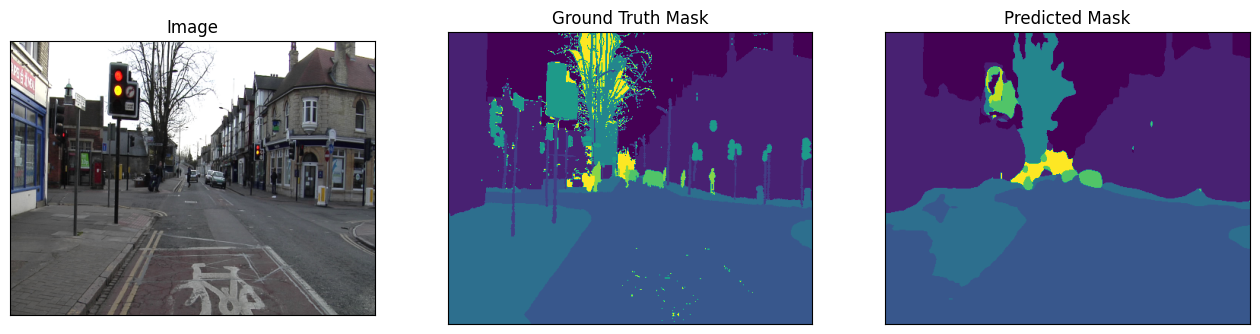

46
torch.Size([3, 384, 480])
torch.Size([1, 12, 384, 480])
torch.Size([1, 384, 480])
(384, 480) torch.Size([12, 384, 480])
(384, 480) torch.Size([384, 480])


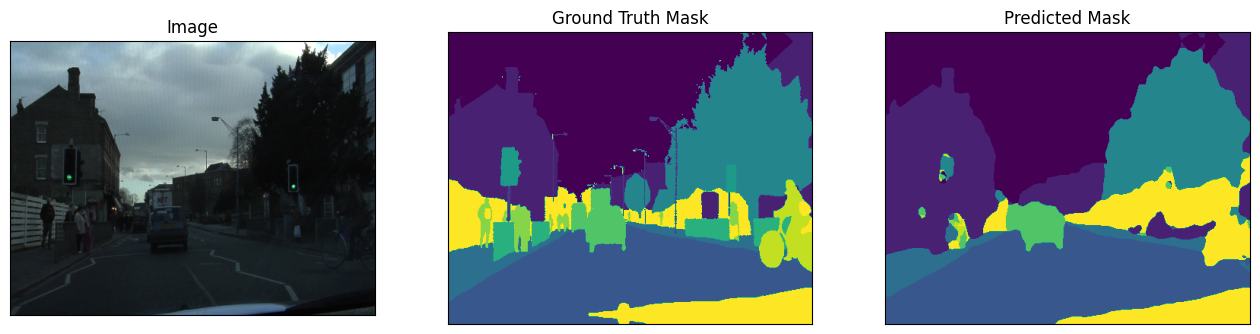

In [44]:
# 1. 学習モデルの読み込み
best_model = torch.load(pathlib.Path("_best_model.pth").as_posix())

# 2. 推論用のデータセット、データローダーの作成
test_dataset = MyDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(None),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)

n_data = 2 # 確認するデータの数
for i in range(n_data):
    n = np.random.choice(len(test_dataset))
    print(n)

    # 3. 新規データの取得
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    print(image.shape)
    
    # 3. 新規データの推論
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)    
    print(pr_mask.shape)
    pr_mask = torch.argmax(pr_mask, dim=1)
    print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())       
    print(pr_mask.shape, gt_mask.shape)
        
    gt_mask = torch.argmax(gt_mask, dim=0)
        
    print(pr_mask.shape, gt_mask.shape)
        
    # 4. 可視化
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )